# Hidden Markov Model



Tal cual como redes Bayesianas con probabilidades discretas, también es posible estudiar secuencias temporales discretas. Estas secuencias se dan en muchas problemas en que necesitamos clasificar el estado de un proceso (oculto o latente) $Z$ que toma valores (discretos o contínuos) a los que tenemos acceso a través de  variables observadas $X$.  


Sin embargo, si sabemos que el proceso $Z$ tiene la propiedad de Markov de primer orden $p(z_k \vert z_{k-1},\ldots,z_1)=p(z_k \vert z_{k-1})$ y que las observaciones $X$ son independientes entre si y solamente dependen de la variable oculta.

Las variables observadas pueden ser variables discretas o continuas. Cuando se consideran v.a. discretas, podemos especificar una matriz $\boldsymbol{A}_{[N \times N]}$ de transición para los $N$ posibles estados, una matriz de emisión $\boldsymbol{B}_{[M \times N]}$ y un conjunto de probabilidades iniciales $\boldsymbol{\pi}$.

$
\begin{align*}
\boldsymbol{A}_{n,n} =
\begin{pmatrix}
z_{1,1} & z_{1,2} & \cdots & z_{1,N} \\
z_{2,1} & z_{2,2} & \cdots & z_{2,N} \\
\vdots  & \vdots  & \ddots & \vdots  \\
z_{N,1} & z_{N,2} & \cdots & z_{N,N}
\end{pmatrix};\quad
&\boldsymbol{B}_{m,n} =
\begin{pmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,N} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,N} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{M,1} & x_{M,2} & \cdots & x_{M,N}
\end{pmatrix}; \quad
\boldsymbol{\pi}=[\pi_1,\ldots,\pi_N]
\end{align*}
$

Dado un modelo $\lambda=(\boldsymbol{A,B,\pi})$, una secuencia observada $X_n=\{x_1,\ldots,x_n\}$ y un conjunto de estados $Z_n=\{z_1,\ldots,z_n\}$, los patrones de inferencia para HMM son los siguientes:

Filtrado : Determinar $p(z_n \vert X_n)$.

Verosimilitud :  Determinar $p(X_n)$.

Secuencia más probable :  $p(Z_n \vert X_n)$.

In [91]:
import numpy as np

class HMM:

    def __init__(self,A,B,pi):
        self.A = A
        self.B = B
        self.pi = pi

    def alpha_recursion(self,observations):
        D=len(self.pi)
        T=len(observations)
        alpha=np.zeros((D,T))
        alpha[:,0]=self.pi*self.B[observations[0]]
        #alpha[:,0]=alpha[:,0]/alpha[:,0].sum()
        for i in range(1,T):
            alpha[:,i]=np.dot(np.diag(self.B[observations[i]]),np.dot(self.A.T,alpha[:,i-1]))
            #alpha[:,i]=alpha[:,i]/alpha[:,i].sum()
        return alpha

    def beta_recursion(self,observations):
        D=len(self.pi)
        T=len(observations)
        beta=np.zeros((D,T+1))
        beta[:,-1]=np.ones(D)
        for i in range(T-1,-1,-1):
            beta[:,i]=np.dot(self.A,np.diag(self.B[observations[i]]).dot(beta[:,i+1]))
        return beta

    def likelihood(self,observations):
        alpha=self.alpha_recursion(observations)
        likelihood=np.sum(alpha,0)
        return likelihood.sum()



# ¿Lloverá o estará despejado?

Queremos modelar la probabilidad de que esté lloviendo $P(R)=\{0,1\}$ dado que observamos que otras personas llevan $U=1$ o no llevan paraguas $U=0$.

La probabilidad de transición entre el estado lluvia de un dia al siguiente está dado por:

|       | R_t+1=1 | R_t+1=0 |
|-------|--------|---------|
| R_t=1 | 0.7    | 0.3     |
| R_t=0 | 0.3    | 0.7     |

Por otra parte, al observador el paraguas tenemos una distribución condicional para la lluvia

|       | U_t=1 | U_t=0 |
|-------|-------|-------|
| R_t=1 | 0.9   | 0.1   |
| R_t=0 | 0.2   | 0.8   |

Finalmente, la probabilidad aprior de la lluvia es de un 50%.


In [92]:
B=np.array([[0.9,0.2],
           [0.1,0.8]])
A=np.array([[0.7,0.3],
            [0.3,0.7]])
pi=np.array([0.5,0.5])
observations=np.array([0,0,1,0,0])


hmm=HMM(A,B,pi)

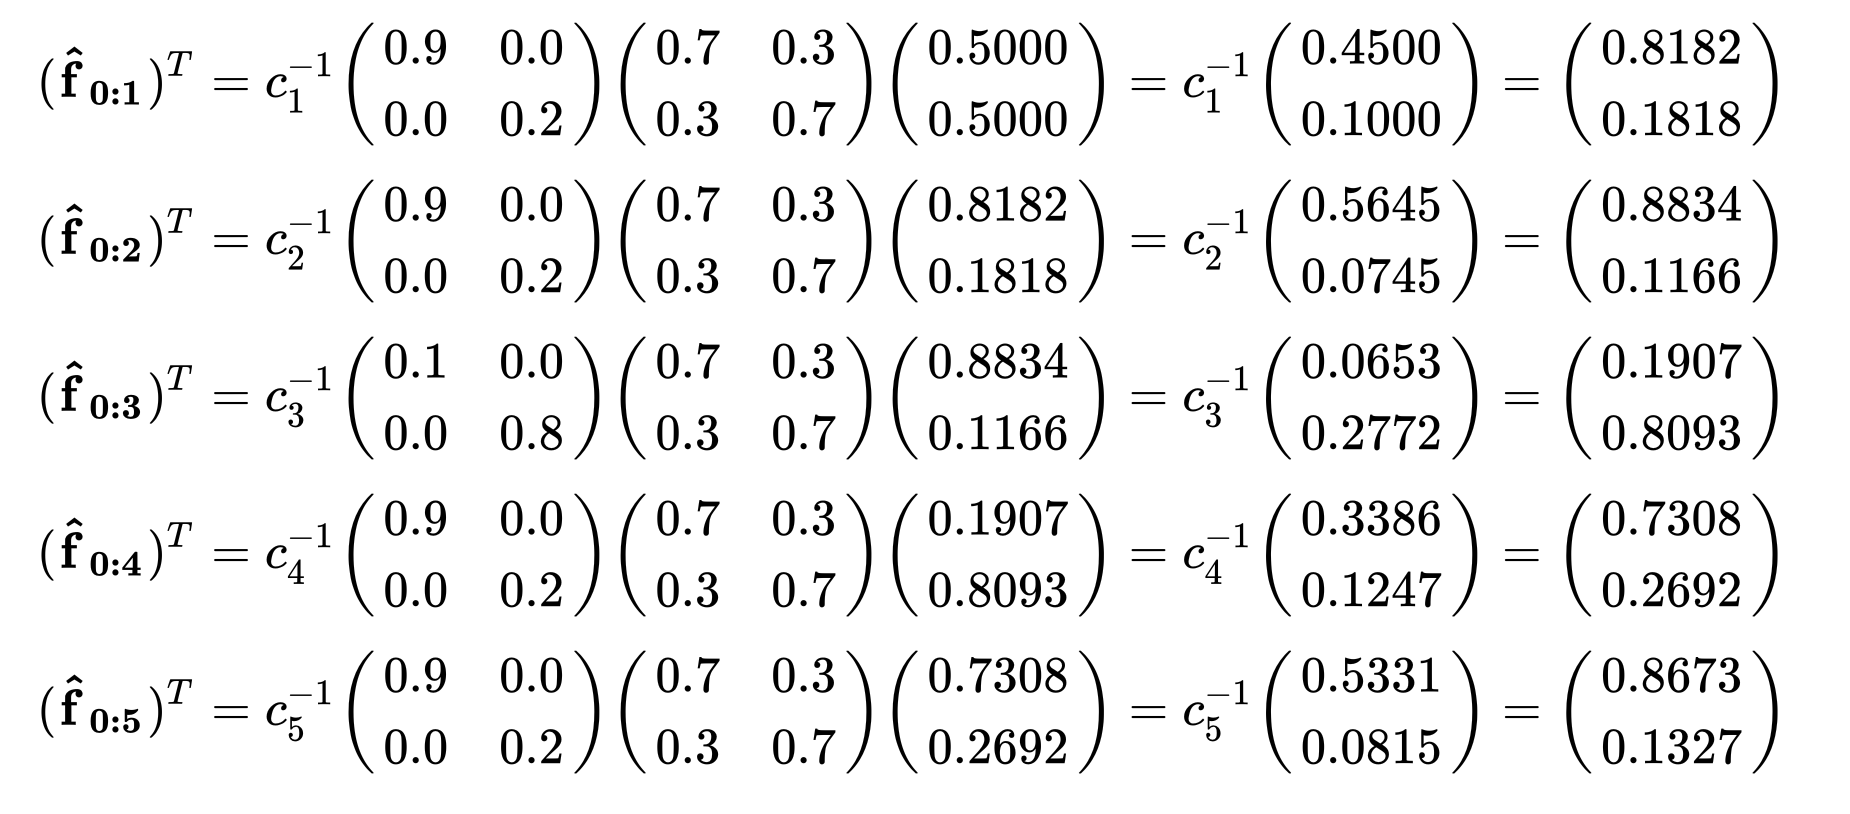

In [63]:
alpha=hmm.alpha_recursion(observations)

In [69]:
alpha_norm=alpha/alpha.sum(axis=0)

for i in range(alpha_norm.shape[1]):
    print('alpha {0} : {1}'.format(i,alpha_norm[:,i].round(decimals=4)))

alpha 0 : [0.8182 0.1818]
alpha 1 : [0.8834 0.1166]
alpha 2 : [0.1907 0.8093]
alpha 3 : [0.7308 0.2692]
alpha 4 : [0.8673 0.1327]


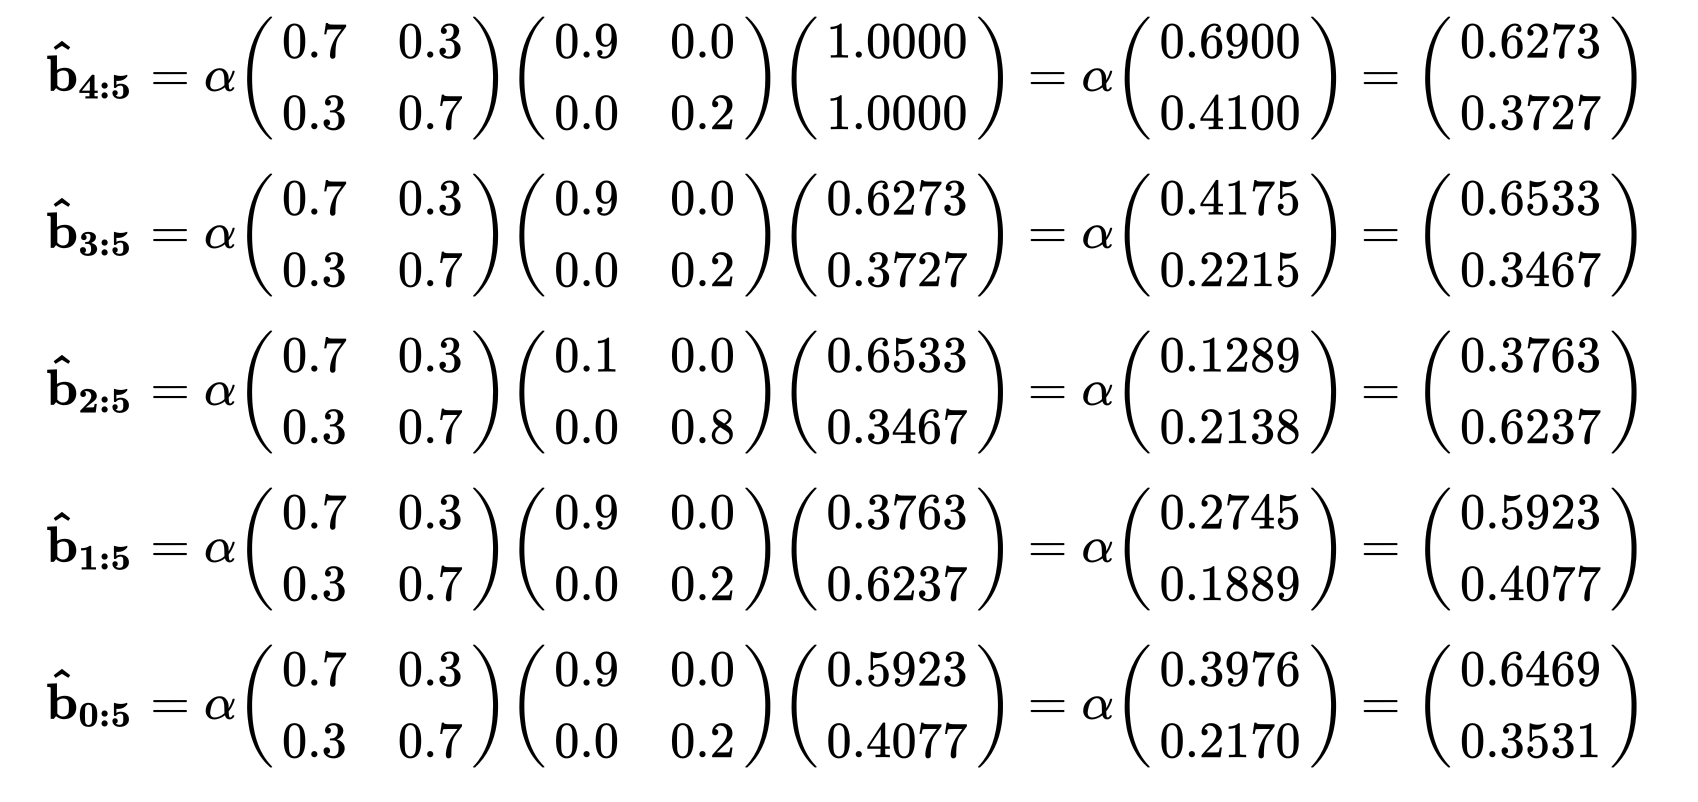

In [96]:
beta=hmm.beta_recursion(observations)
beta_norm=beta/beta.sum(axis=0)

for i in range(beta_norm.shape[1]):
    print('beta {0} : {1}'.format(i,beta_norm[:,i].round(decimals=4)))

beta 0 : [0.6469 0.3531]
beta 1 : [0.5923 0.4077]
beta 2 : [0.3763 0.6237]
beta 3 : [0.6533 0.3467]
beta 4 : [0.6273 0.3727]
beta 5 : [0.5 0.5]


# Human Activity Recognition

En este laboratorio usaremos registro de actividades capturado por smartphones que fueron desarrolladas por 30 personas distintas. Entre las actividades se incluyen:

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING

Al mismo tiempo, cada registro de la base de datos incluye las siguientes mediciones:ç

Aceleracion total y aceleracion del cuerpo estimada en los 3 ejes (X-Y-Z)
Velocidad angular del giroscopio en 3 los ejes (X-Y-Z)
Un vector de dimensionalidad 561 con descriptores derivados a partir de los datos de movimiento.
Etiqueta de actividad
Un identificador de la persona que ejecuta la actividad
Los datos originales se pueden encontrar en este enlace

Más información del dataset se encuentra en:

Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False


print('Google Colab? ',IS_COLAB)

('Google Colab? ', True)


In [ ]:
if IS_COLAB:
    ! wget  -c "https://ucmcl-my.sharepoint.com/:u:/g/personal/shernandez_ucm_cl/EWvE2qLEt7lGkusfUcjYHnMBbtVOqIrdzY15Dnd2hHDUJA?e=NAeghv&download=1" -O HAR.tar.xz
    ! tar -xf HAR.tar.xz

--2021-07-08 20:01:37--  https://ucmcl-my.sharepoint.com/:u:/g/personal/shernandez_ucm_cl/EWvE2qLEt7lGkusfUcjYHnMBbtVOqIrdzY15Dnd2hHDUJA?e=NAeghv&download=1
Resolving ucmcl-my.sharepoint.com (ucmcl-my.sharepoint.com)... 13.107.136.9
Connecting to ucmcl-my.sharepoint.com (ucmcl-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/shernandez_ucm_cl/Documents/HAR.tar.xz?originalPath=aHR0cHM6Ly91Y21jbC1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9zaGVybmFuZGV6X3VjbV9jbC9FV3ZFMnFMRXQ3bEdrdXNmVWNqWUhuTUJidFZPcUlyZHpZMTVEbmQyaEhEVUpBP3J0aW1lPWFZakNNVXRDMlVn [following]
--2021-07-08 20:01:37--  https://ucmcl-my.sharepoint.com/personal/shernandez_ucm_cl/Documents/HAR.tar.xz?originalPath=aHR0cHM6Ly91Y21jbC1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9zaGVybmFuZGV6X3VjbV9jbC9FV3ZFMnFMRXQ3bEdrdXNmVWNqWUhuTUJidFZPcUlyZHpZMTVEbmQyaEhEVUpBP3J0aW1lPWFZakNNVXRDMlVn
Reusing existing connection to ucmcl-my.sharepoint.com:443.
HTTP request 

In [ ]:
! ls HAR

x_test.npy  x_train.npy  y_test.npy  y_train.npy


In [ ]:
import numpy as np

X_train=np.load('HAR/x_train.npy')
X_test=np.load('HAR/x_test.npy')
y_train=np.load('HAR/y_train.npy')
y_test=np.load('HAR/y_test.npy')

label_to_activity = {1: 'walking horizontally', 2: 'walking upstairs', 3: 'walking downstairs',
                     4: 'sitting', 5: 'standing', 6: 'laying'}

In [ ]:
y_train.shape

(7352, 1)

In [ ]:
X_train.shape

(7352, 128, 9)

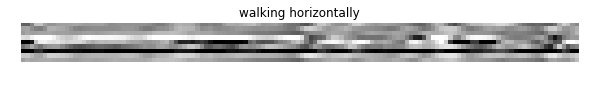

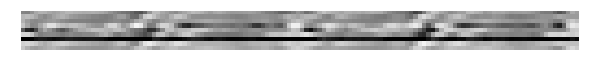

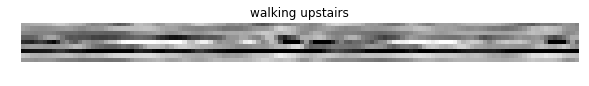

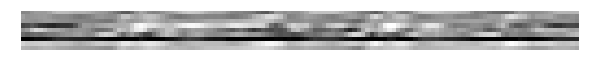

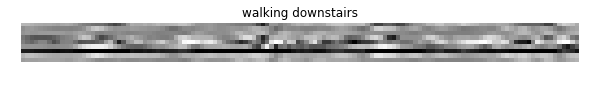

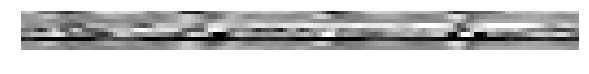

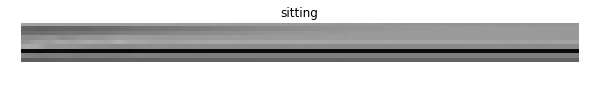

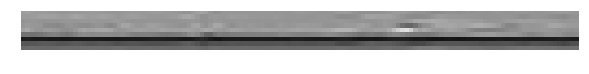

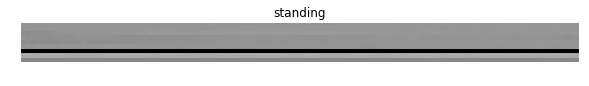

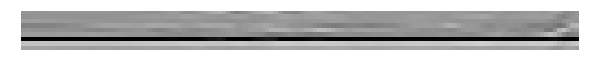

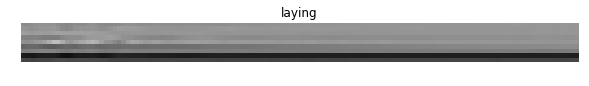

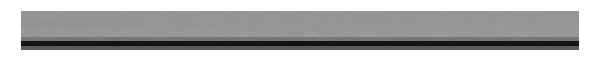

In [ ]:
import matplotlib.pyplot as plt

def make_plots(num_examples_per_category):
    for label in range(1,7):
        x_label = X_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()

make_plots(2)

In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 153kB 28.3MB/s 
  Created wheel for hmmlearn: filename=hmmlearn-0.2.2-cp27-cp27mu-linux_x86_64.whl size=189250 sha256=24e0927d5f367da31201878c2198edc5e1fb199e61a553c54ad97cf6d550ac2b
  Stored in directory: /root/.cache/pip/wheels/2c/b6/0e/63a865a30e21e01d04f417d8995fbfb793d6bd464707efc546
Successfully built hmmlearn


In [ ]:
X_activity=X_train[(y_train==1).flatten()]

In [ ]:
lengths=[X_activity.shape[1]]*X_activity.shape[0]

In [ ]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)

In [ ]:
model.fit(X_activity.reshape([X_activity.shape[0]*X_activity.shape[1],X_activity.shape[2]]),lengths)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

Text(0,0.5,'Observation ')

<Figure size 720x72 with 0 Axes>

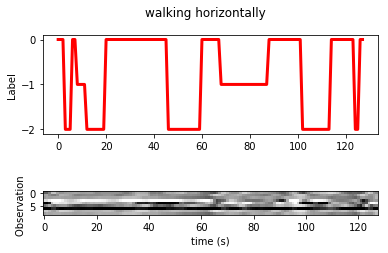

In [ ]:
Z=model.predict(X_activity[0])
label=y_train[(y_train==1)][0]
plt.figure(figsize=(10, 1))
fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle(label_to_activity[label])

ax1.plot(range(128),(Z-2),color="r",linewidth=3)
ax1.set_ylabel('Label')

ax2.imshow(X_activity[0].T, cmap='Greys', vmin=-1, vmax=1)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Observation ')



In [ ]:
model_activities={activity:hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
                    for activity in label_to_activity.keys()}

In [ ]:
model_activities

{1: GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=100, params='stmc',
       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 2: GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=100, params='stmc',
       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 3: GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
       min_covar=0.001, n_components=3, n_iter=100, params='stmc',
       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
       verbose=False),
 4: GaussianHMM(algorithm='viterbi

In [ ]:
for id,model in model_activities.iteritems():
  X_activity=X_train[(y_train==id).flatten()]
  lengths=[X_activity.shape[1]]*X_activity.shape[0]
  model.fit(X_activity.reshape([X_activity.shape[0]*X_activity.shape[1],X_activity.shape[2]]),lengths)

In [ ]:
y_hat=[]
for id_example in range(X_test.shape[0]):
  predicted_label_arr=[]
  for id,model in model_activities.iteritems():
    predicted_label_arr.append(model.score(X_test[id_example]))
  predicted_label=np.array(predicted_label_arr).argmax()+1
  y_hat.append(predicted_label)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(y_test.reshape(-1)),np.int32(y_hat)))

              precision    recall  f1-score   support

           1       0.65      0.86      0.74       496
           2       0.93      0.66      0.77       471
           3       0.75      0.74      0.75       420
           4       0.91      0.69      0.78       491
           5       0.77      0.91      0.84       532
           6       1.00      1.00      1.00       537

   micro avg       0.82      0.82      0.82      2947
   macro avg       0.84      0.81      0.81      2947
weighted avg       0.84      0.82      0.82      2947



In [ ]:
X_test.shape

(2947, 128, 9)